# Space Flight Mice Liver Gene Analysis
## Heat Propagation and Clustering Package
### Python 2 compatible version

----------------------

Author: Mikayla Webster (13webstermj@gmail.com)

Date: 6th April, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Define Analysis Preferences](#pref)
3. [Load Networks](#load)
4. [Localization](#local)
4. [Run Heat Propagation](#heat)
5. [Clustering](#cluster)
6. [Write to File](#write)

## Background
<a id='background'></a>

The Heat2 module provides tools to conduct an integrated network analysis of a set of differentially expressed genes (DEGs). The set of DEGs analyzed in this notebook come from an experiment performed by NASA called the [Rodent Research Project on the ISS](https://genelab-data.ndc.nasa.gov/genelab/accession/GLDS-48). The tissues sampled for this experiment were taken from the livers of mice who experienced space flight. 

The focus of this notebook is to show all available tools in the Heat Propogation and Clustering workflow.

## Import packages
<a id='import'></a>

In [112]:
import sys
code_path = '../../network_bio_toolkit'
sys.path.append(code_path)

import Heat2
reload(Heat2)

<module 'Heat2' from '../../network_bio_toolkit\Heat2.py'>

## Define Analysis Preferences
<a id='pref'></a>

In [113]:
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

heat = Heat2.Heat(gene_type = symbol, species = mouse)

## Load Networks
<a id='load'></a>

1. Load STRING background network
2. Load DEG file 

In [114]:
filename = '../../background_networks/10090.protein.links.v10.5.txt'
heat.load_STRING_links(filename, confidence_filter = 700)

print('\nNumber of interactions: ' + str(len(list(heat.DG_universe.edges()))))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13911...done.
Finished.
70 input query terms found dup hits:
	[(u'ENSMUSP00000092661', 2), (u'ENSMUSP00000001415', 2), (u'ENSMUSP00000136781', 2), (u'ENSMUSP00000
410 input query terms found no hit:
	[u'ENSMUSP00000137120', u'ENSMUSP00000128098', u'ENSMUSP00000136100', u'ENSMUSP00000039192', u'ENSMU
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

Number of interactions: 368642


In [116]:
# for testing purposes only. Not necesary for analysis.
saved_DG_universe = heat.DG_universe
heat.DG_universe = saved_DG_universe

In [117]:
# load DEG file
DEG_filename = '../../DEG_databases/DE_CoeffspaceFlight - groundControl_glds48_20180312.csv'  
heat.create_DEG_list(DEG_filename, p_value_filter = 0.02, sep = ',')

print('Number of DEG\'s: ' + str(len(heat.DEG_list)))

Number of DEG's: 45


## Localization
<a id='local'></a>

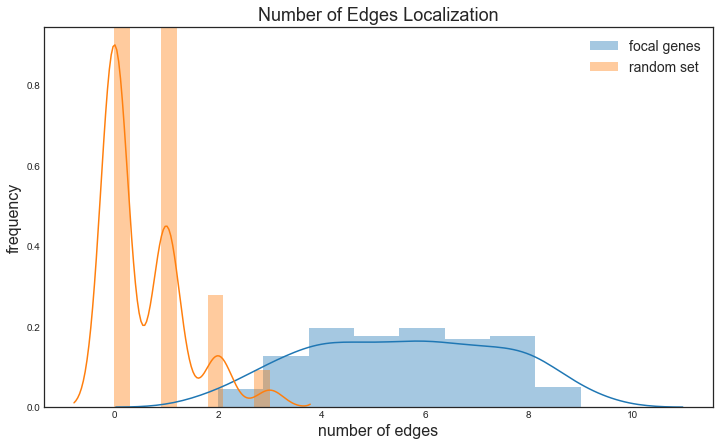

In [118]:
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization(num_reps = 250, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'numedges', 
                                                                     plot = True)

0.0


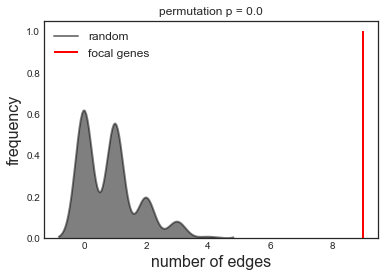

In [119]:
# test out plotting parameters with a smaller num_reps first.
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization_full(num_reps = 200, 
                                                                          method = 'numedges', 
                                                                          label = 'focal genes',
                                                                          line_height = 1,
                                                                          legend_loc = 'upper left')

## Run Heat Propagation
<a id='heat'></a>

In [120]:
heat.normalized_adj_matrix()

In [121]:
# for testing purposes only. Not necesary for analysis.
saved_Wprime = heat.Wprime
heat.Wprime = saved_Wprime

In [122]:
heat.draw_heat_prop(num_nodes = 200,
                  random_walk = True,
                  edge_width = 2,
                  edge_smooth_enabled = True,
                  edge_smooth_type = 'bezier',
                  node_size_multiplier = 5,
                  hover = False,
                  hover_connected_edges = False,
                  largest_connected_component = True,
                  physics_enabled = True,
                  node_font_size = 40,
                  graph_id = 1,
                  node_shadow_x = 6)

## Clustering 
<a id='cluster'></a>

Parameter information:
- **G_DEG**: background network filtered by DEG list, output of load_STRING_to_digraph
- **DG_universe**: full background network, output of create_graph.load_STRING_to_digraph 
- **seed_nodes**: list of DEG's, output of create_graph.create_DEG_list
- **Wprime**: will calculate automatically of not specified, output of visualizations.normalized_adj_matrix
- **num_top_genes**: number of genes to display in the output graph
- **cluster_size_cut_off**: color clusters below this threshhold grey
- **remove_stray_nodes**: remove custers below the cluster size cut off
- **r**: increases spacing between clusters. recommended number between 0.5 and 4.0
- **x_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **y_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **node_spacing**: recommended number between 500 and 2000
- **node_size_multiplier**: as you scale node_spacing, scale this number. Recommended number between 5 and 25
- **physics_enabled**: Nodes will bounce aroound when you click and drag them. Only set to True when number of nodes is 200 or less
- **node_font_size**: as you scale node_spacing, scale this number. Recommended number between 20 and 50
- **graph_id**: Allows rendering of multiple graphs in one notebook. Just make sure each graph has a unique id. 

In [123]:
heat.draw_clustering(rad_positions = False,
                k = None,
                largest_connected_component = True,
                num_top_genes = 200,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                node_spacing = 700,
                node_size_multiplier = 10,
                physics_enabled = True,
                node_font_size = 40,
                graph_id = 2,
                edge_width = 2,
                edge_smooth_enabled = True,
                edge_smooth_type = 'bezier',
                hover = False,
                hover_connected_edges = False
               )

167


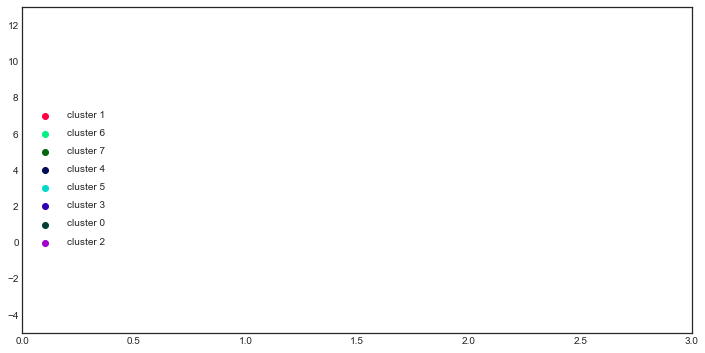

In [124]:
heat.cluster_legend(cluster_size_cut_off = 5)

In [125]:
heat.draw_clustering(num_top_genes = 200,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                r = 0.4,
                node_spacing = 600,
                node_size_multiplier = 4,
                physics_enabled = False,
                node_font_size = 15,
                graph_id = 3,
                node_shadow_x = 6,
                color_lfc = True,
                largest_connected_component = True,
                vmin = -1,
                vmax = 1
               )

167


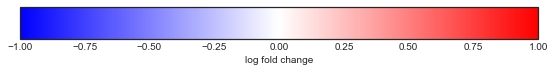

In [126]:
heat.draw_legend(vmin = -1, vmax = 1, label = 'log fold change')

## Write to file
<a id='write'></a>

In [127]:
#heat.write_cluster_table('cluster_table_2.csv')